Drive Mounted

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Data

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

TensorFlow version: 2.17.1
Keras version: 3.5.0


NameError: name 'numpy' is not defined

In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing and evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
from tqdm import tqdm

# TensorFlow/Keras for deep learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, BatchNormalization, GRU,
    Input, Flatten, Dropout, Activation, Conv1D,
    MaxPooling1D, AveragePooling1D
)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
import tensorflow as tf
print ("Done")

Done


In [ ]:
#preparing data set

ravdess = "/content/drive/MyDrive/ML Team 35/Codes/SER/datasets/RAVDESS/"
#ravdess_directory_list = os.listdir(ravdess)
ravdess_directory_list = sorted(os.listdir(ravdess))  # 对文件名进行排序
print(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


preprocessing datasets (RAVDESS)

In [ ]:
file_emotion = [] #儲存每個audio的emotion label
file_path = [] #儲存每個audio的完整path
for i in ravdess_directory_list:
    # as their are 24 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(ravdess + i)
    for f in actor:
        part = f.split('.')[0].split('-')
    # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(ravdess + i + '/' + f)
        #file_path.append(i + '/' + f)
#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised)

In [ ]:
print(actor[0])
print(part[0])
print(file_path[0])
print(int(part[2]))
print(f)

03-01-02-02-02-01-24.wav
03
/content/drive/MyDrive/ML Team 35/Codes/SER/datasets/RAVDESS/Actor_01/03-01-02-02-02-01-01.wav
8
03-01-08-02-02-02-24.wav


In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
ravdess_df['Emotions'] = ravdess_df['Emotions'].replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad',
    5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
})

print(ravdess_df.head())
print("______________________________________________")
print(ravdess_df.tail())
print("_______________________________________________")
print(ravdess_df.Emotions.value_counts())

  Emotions                                               Path
0     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
1     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
2     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
3  neutral  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
4     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
______________________________________________
       Emotions                                               Path
1435  surprised  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
1436  surprised  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
1437  surprised  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
1438  surprised  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
1439  surprised  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
_______________________________________________
Emotions
calm         192
happy        192
angry        192
sad          192
surprised    192
fearful      192
disgust      192
neu

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
#data_path = pd.concat([ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path = pd.concat([ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
1     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
2     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
3  neutral  /content/drive/MyDrive/ML Team 35/Codes/SER/da...
4     calm  /content/drive/MyDrive/ML Team 35/Codes/SER/da...

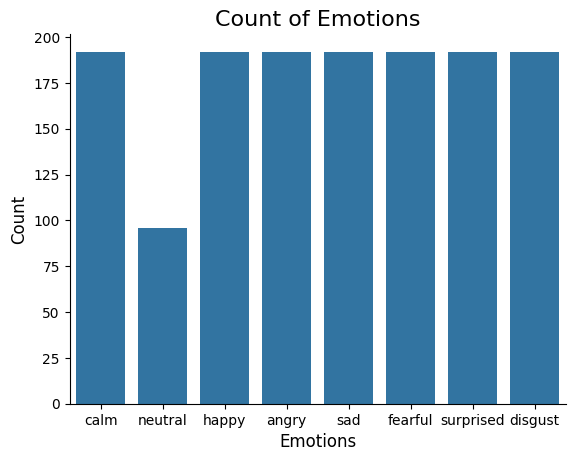

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.Emotions)  # 明确指定 x 轴为 Emotions
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


In [ ]:
data,sr = librosa.load(file_path[0]) #將audio轉換為可以處理的數字信號
print(sr) #采樣率，每秒audio採樣的次數，默認是22050Hz
print(data)
print(file_path[0])

22050
[ 2.4291885e-05  2.9232147e-05  8.0483096e-06 ...  5.9485018e-08
 -1.5443162e-06 -1.3785519e-05]
/content/drive/MyDrive/ML Team 35/Codes/SER/datasets/RAVDESS/Actor_01/03-01-02-02-02-01-01.wav


In [ ]:
ipd.Audio(data,rate=sr) #播放音頻，rate=sr確保audio以正確的速度播放

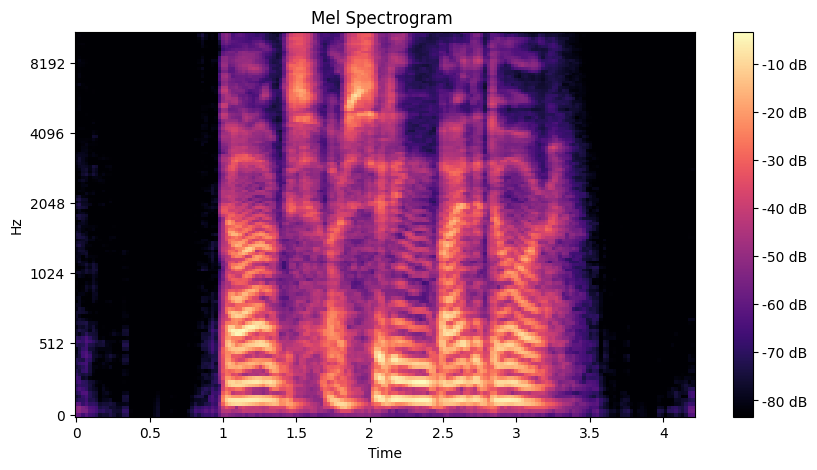

In [ ]:
# CREATE LOG MEL SPECTROGRAM 為音頻生成對數梅爾譜圖
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
# audio data，采樣率，梅爾濾波器的數量（頻率分辨率），最大頻率限制
# spectrogram：二維數組，表示時間和頻率的能量分佈
log_spectrogram = librosa.power_to_db(spectrogram)
# 將譜圖的功率值轉換為對數刻度（以分貝為單位），類似於聲音的強度
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB')

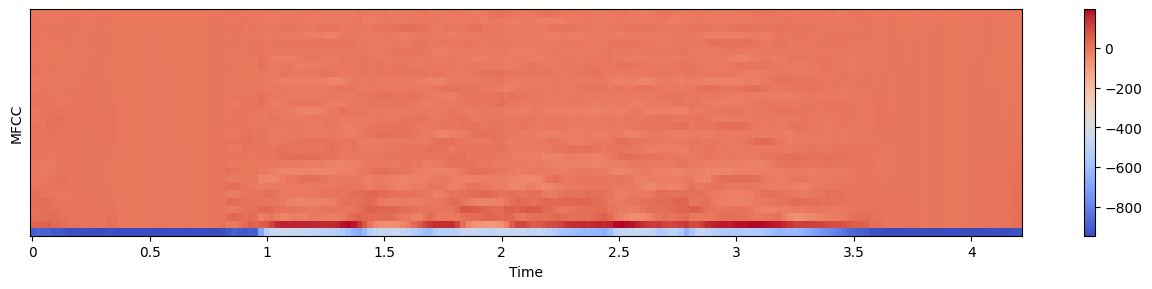

In [ ]:
mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=30)
# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(data,rate=sr)
#MFCC是通過對audio的頻譜進行梅爾變換和倒譜變換後提取的特征
#一種低緯、高信息密度的音頻特征表示，能有效表示語音的聲音特性

Data augmenttation 數據增強

In [ ]:
# NOISE
# 添加隨機噪聲，模擬真實環境中的背景干擾，提供model對噪聲的robustness（穩健性）
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data) #噪聲的振幅
    data = data + noise_amp*np.random.normal(size=data.shape[0]) #生成與audio漲肚相同的高斯分佈隨機數
    return data

# STRETCH
# 通過時間拉伸/壓縮，模擬不同的語速或播放速度
# 改變audio的播放速度，同時保持頻率不變
# rate<1: 減慢（拉伸）， rate>1：加快（縮短）
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# SHIFT
# 對audio signal進行時間平移，模擬不同的開始時間，例如不同時刻的錄音開始點
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000) #範圍為-5秒到5秒
    return np.roll(data, shift_range)

# PITCH
# 調整audio的音高，模擬不同的音調高低，例如男性和女性的音高差異
# pitch_factor>1：升高，pitch_factor<1: 降低
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

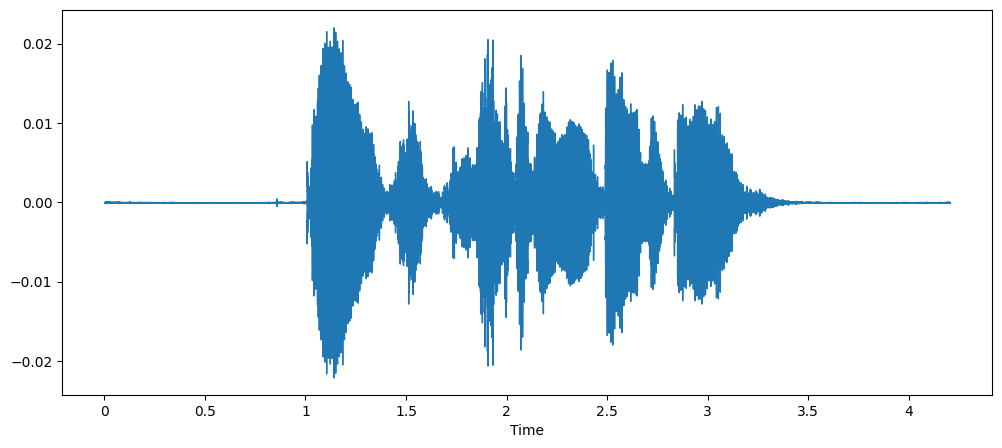

In [ ]:
# NORMAL AUDIO
import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sr)
ipd.Audio(data,rate=sr)

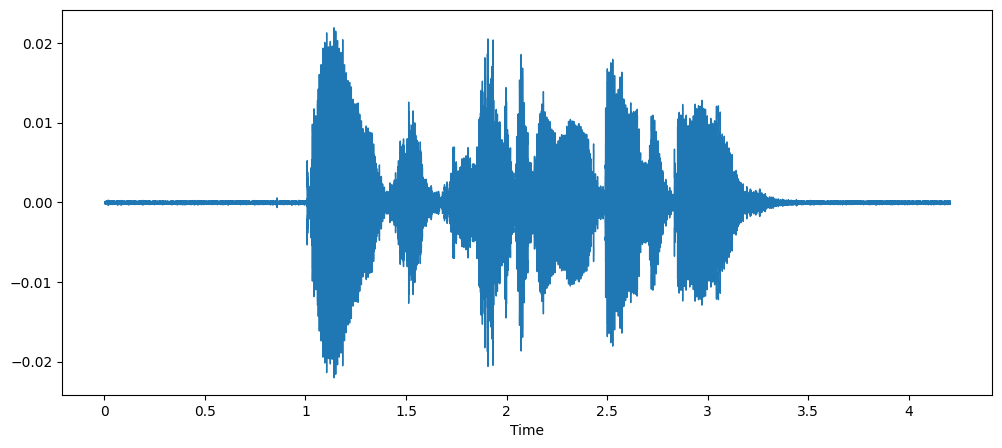

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

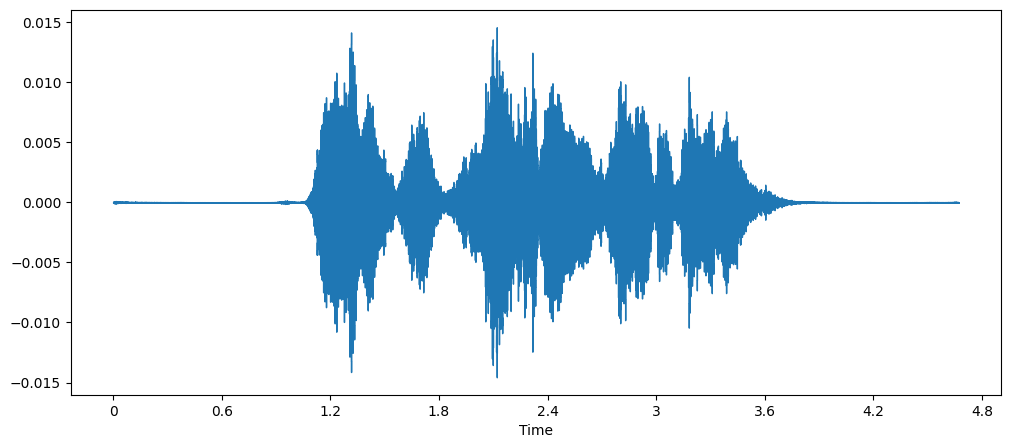

In [ ]:
# STRETCHED AUDIO
x = stretch(data,0.9)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

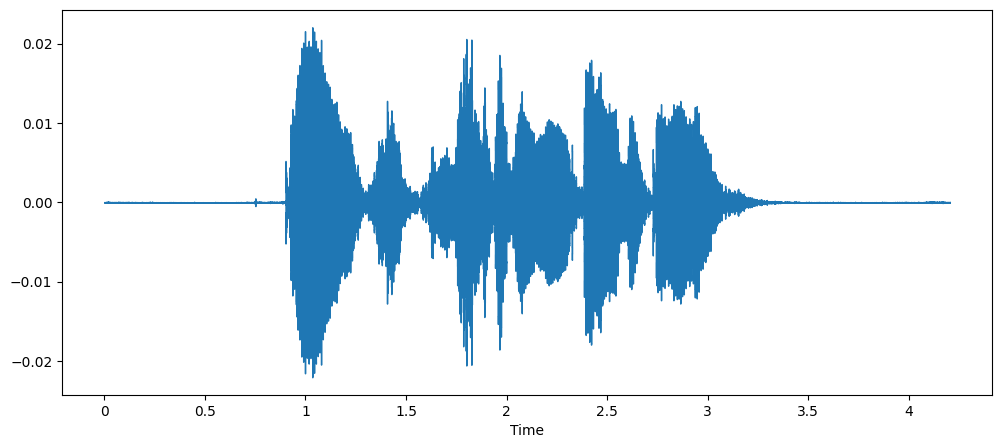

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

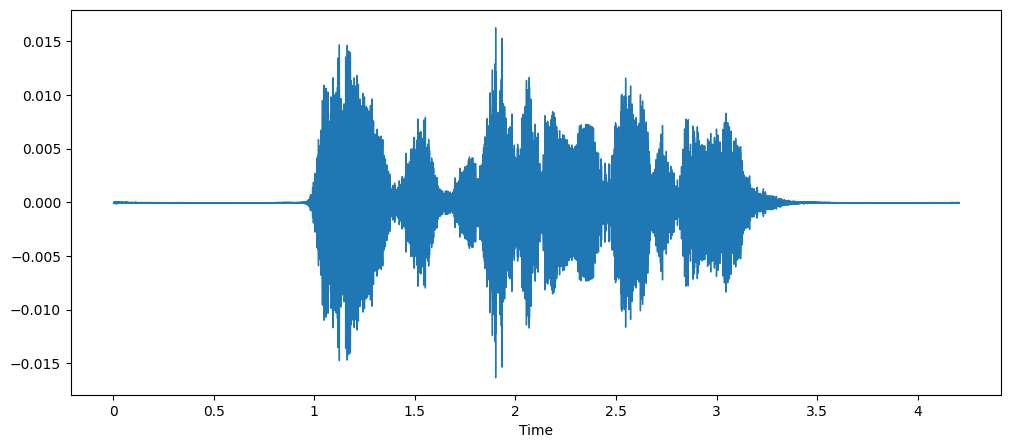

In [ ]:
# AUDIO WITH PITCH
x = pitch(data, sampling_rate=sr, pitch_factor=2.0)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sr)
ipd.Audio(x, rate=sr)

Feature extraction 特征提取

In [ ]:
#計算過零率Zero Crossing Rate，反映audio的頻率特性
#高頻音：如尖銳聲，ZCR較高；低頻音：如人聲或樂器，ZCR較低
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

#計算均方根能量Root Mean Square Energy，衡量audio signal在每一幀中的能量大小
#RMSE高的部分通常對應響亮的音頻片段
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

#提取音頻的MFCC（梅爾頻率倒譜係數），提取音頻的主要頻率信息
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

#從audio中提取多個特征拼接成一個特征向量
def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

#從audio中提取特征，並通過audio增強技術生成多個變體的特征
def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data)
    audio=np.array(aud)

    noised_audio=noise(data)
    aud2=extract_features(noised_audio)
    audio=np.vstack((audio,aud2))

    pitched_audio=pitch(data,sr)
    aud3=extract_features(pitched_audio)
    audio=np.vstack((audio,aud3))

    pitched_audio1=pitch(data,sr)
    pitched_noised_audio=noise(pitched_audio1)
    aud4=extract_features(pitched_noised_audio)
    audio=np.vstack((audio,aud4))

    return audio

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12


In [ ]:
import tensorflow as tf
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


GPU is available


Normal way to get features

In [ ]:
import timeit
from tqdm import tqdm
start = timeit.default_timer()
X,Y=[],[]
for path,emotion,index in tqdm (zip(data_path.Path,data_path.Emotions,range(data_path.Path.shape[0]))):
    features=get_features(path)
    if index%500==0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)
print('Done')
stop = timeit.default_timer()

print('Time: ', stop - start)

1it [00:00,  5.32it/s]

0 audio has been processed


501it [04:37,  2.04it/s]

500 audio has been processed


1001it [09:19,  1.79it/s]

1000 audio has been processed


1440it [13:26,  1.79it/s]

Done
Time:  806.5933170649998


Saving features

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()
#X軸（列）：每列代表一個特征
#Y軸（行）：每行對應一個audio

0         1         2         3         4         5         6  \
0  0.000000  0.146973  0.253906  0.401367  0.401367  0.333496  0.447266   
1  0.250488  0.385742  0.514160  0.529297  0.516602  0.496094  0.499512   
2  0.281250  0.405762  0.519043  0.511230  0.470215  0.445312  0.436035   
3  0.237305  0.355957  0.465820  0.483887  0.491211  0.497559  0.509766   
4  0.413086  0.579590  0.714355  0.628418  0.580078  0.529785  0.500000   

          7         8         9  ...      2367       2368      2369      2370  \
0  0.519043  0.682129  0.793457  ...  6.639688  15.353042  0.831992 -1.574779   
1  0.491211  0.499512  0.514160  ...  5.988808  12.921778  2.609187 -0.046463   
2  0.443359  0.493652  0.530273  ...  8.750324  14.381288 -2.759678  1.557964   
3  0.500977  0.507324  0.502930  ...  8.876002   9.376677  2.677087  0.283571   
4  0.467285  0.481934  0.552734  ... -2.019665 -18.506268 -1.873260  2.607319   

       2371      2372      2373      2374      2375  Emotions  
0 -2.067524 -7.427416 -5.868529 -3.095812  5.418613      calm  
1 -4.592659 -5.084562 -8.044055  0.496215  0.478297      calm  
2 -6.362005 -6.173393 -4.470137  4.971821  4.659015      calm  
3 -6.159038 -6.915700 -2.826277  4.858167  0.524799      calm  
4 -8.029386 -1.494768 -1.964761  1.179833  7.383557      calm  

[5 rows x 2377 columns]

In [ ]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

0         1         2         3         4         5         6  \
0  0.000000  0.146973  0.253906  0.401367  0.401367  0.333496  0.447266   
1  0.250488  0.385742  0.514160  0.529297  0.516602  0.496094  0.499512   
2  0.281250  0.405762  0.519043  0.511230  0.470215  0.445312  0.436035   
3  0.237305  0.355957  0.465820  0.483887  0.491211  0.497559  0.509766   
4  0.413086  0.579590  0.714355  0.628418  0.580078  0.529785  0.500000   

          7         8         9  ...      2367       2368      2369      2370  \
0  0.519043  0.682129  0.793457  ...  6.639688  15.353042  0.831992 -1.574779   
1  0.491211  0.499512  0.514160  ...  5.988808  12.921778  2.609187 -0.046463   
2  0.443359  0.493652  0.530273  ...  8.750324  14.381288 -2.759678  1.557964   
3  0.500977  0.507324  0.502930  ...  8.876002   9.376677  2.677087  0.283571   
4  0.467285  0.481934  0.552734  ... -2.019665 -18.506268 -1.873260  2.607319   

       2371      2372      2373      2374      2375  Emotions  
0 -2.067524 -7.427416 -5.868529 -3.095812  5.418613      calm  
1 -4.592659 -5.084562 -8.044055  0.496215  0.478297      calm  
2 -6.362005 -6.173393 -4.470137  4.971821  4.659015      calm  
3 -6.159038 -6.915700 -2.826277  4.858167  0.524799      calm  
4 -8.029386 -1.494768 -1.964761  1.179833  7.383557      calm  

[5 rows x 2377 columns]

In [ ]:
print(Emotions.isna().any())
#如果該列的某個單元格是NaN，會返回True

0           False
1           False
2           False
3           False
4           False
            ...  
2372         True
2373         True
2374         True
2375         True
Emotions    False
Length: 2377, dtype: bool


In [ ]:
Emotions=Emotions.fillna(0) #將NaN替換為0
print(Emotions.isna().any())
Emotions.shape #（行數，列數）=（audio總數量，提取的特征數+emotion label）

0           False
1           False
2           False
3           False
4           False
            ...  
2372        False
2373        False
2374        False
2375        False
Emotions    False
Length: 2377, dtype: bool


(5760, 2377)

In [ ]:
np.sum(Emotions.isna()) #每列NaN的數量

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
2372        0
2373        0
2374        0
2375        0
Emotions    0
Length: 2377, dtype: int64

Data preparation

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions
X = Emotions.iloc[: ,:-1].values #返回特征列（不含最後一列的emotion）
Y = Emotions['Emotions'].values #返回最後一粒（emotion列）
# As this is a multiclass classification problem onehotencoding our Y
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(Y.shape) #（樣本數，類別數）
print(X.shape) #（樣本數，特征數）

(5760, 8)
(5760, 2376)


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=7,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [ ]:
##reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape
x_testcnn[0]

# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4608, 2376), (4608, 8), (1152, 2376), (1152, 8))

In [ ]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(
    'best_model1_weights.keras',  # 修改文件扩展名
    monitor='val_accuracy',
    save_best_only=True
)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_acc', #監控accuracy *val_loss
    mode='max', #val_acc:max, val_loss:min
    patience=5, #等待5個連續epoch性能無提升後，停止訓練
    restore_best_weights=True #訓練停止後，模型的權重會恢復到validation表現最好的那個epoch
)
lr_reduction=ReduceLROnPlateau(
    monitor='val_acc',
    patience=3,
    verbose=1, #輸出學習率調整的信息
    factor=0.5, #每次減少學習率，將其乘以factor
    min_lr=0.00001 #學習率的下限
)

CNN Model

In [ ]:
import tensorflow.keras.layers as L

model = tf.keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the second max pooling layer

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fourth max pooling layer

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),  # Add dropout layer after the fifth max pooling layer

    L.Flatten(),
    L.Dense(512,activation='relu'),
    L.BatchNormalization(),
    L.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 2376, 512)           │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2376, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1188, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1188, 512)           │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1188, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 594, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 594, 256)            │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 594, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 297, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 297, 256)            │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 297, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 149, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 149, 128)            │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 149, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9600)                │              

 Total params: 7,193,736 (27.44 MB)

 Trainable params: 7,189,384 (27.43 MB)

 Non-trainable params: 4,352 (17.00 KB)

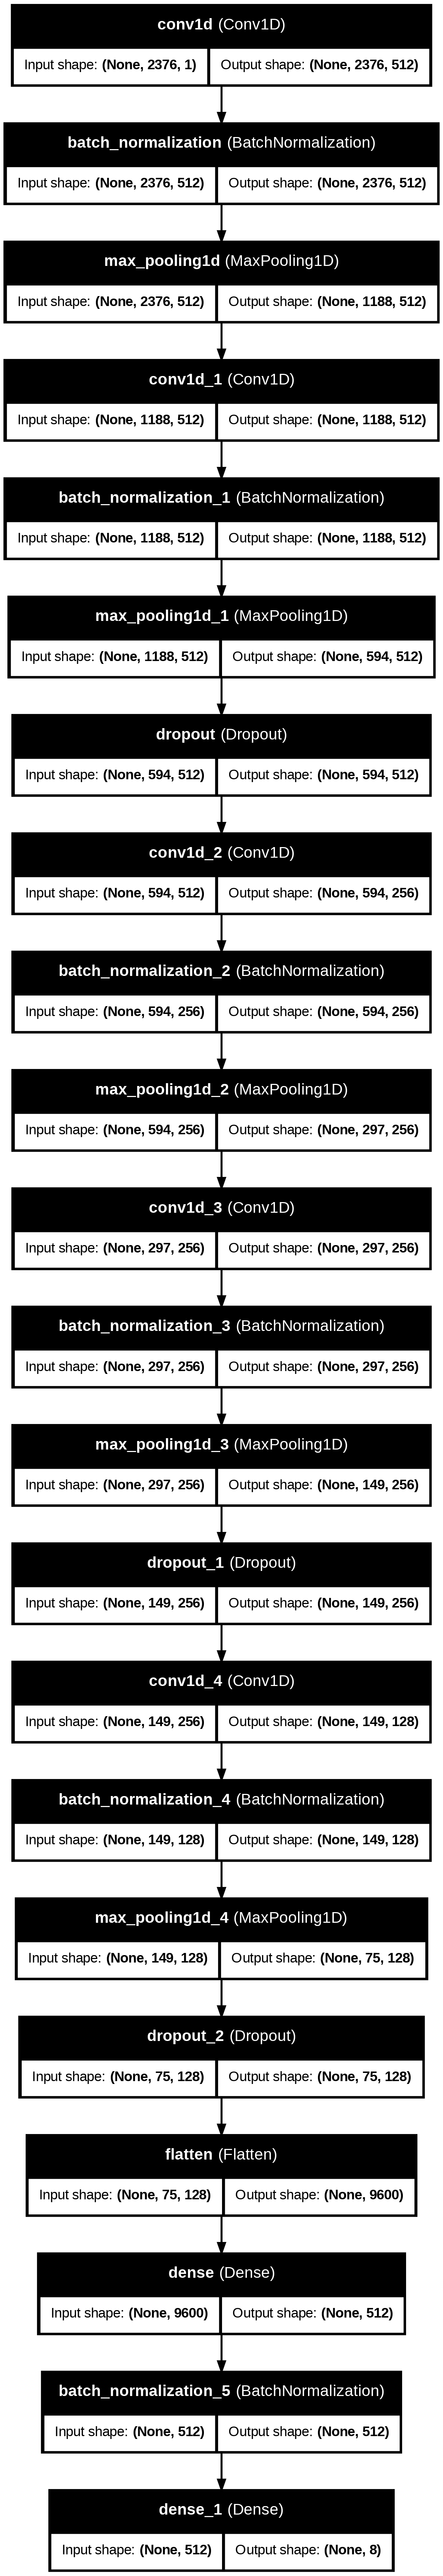

In [ ]:
from tensorflow.keras.utils import plot_model

# 绘制模型结构
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


In [ ]:
history=model.fit(x_traincnn, y_train, epochs=50, validation_data=(x_testcnn, y_test), batch_size=64,callbacks=[early_stop,lr_reduction,model_checkpoint])

Epoch 1/50
70/72 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6048 - loss: 1.1275

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6050 - loss: 1.1261 - val_accuracy: 0.1250 - val_loss: 4.8331 - learning_rate: 0.0010
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.7289 - loss: 0.7693 - val_accuracy: 0.1207 - val_loss: 6.2007 - learning_rate: 0.0010
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8287 - loss: 0.5109 - val_accuracy: 0.1467 - val_loss: 5.5591 - learning_rate: 0.0010
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9073 - loss: 0.3058 - val_accuracy: 0.1259 - val_loss: 5.5693 - learning_rate: 0.0010
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9271 - loss: 0.2396 - val_accuracy: 0.1719 - val_loss: 4.5433 - learning_rate: 0.0010
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9678 - loss: 0.1317 - val_accuracy: 0.2708 - val_loss: 4.3858 - learning_rate: 0.0010
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9797 - loss: 0.0862 - val_accuracy: 0.57

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9343 - loss: 0.2189
Accuracy of our model on test data :  93.31597089767456 %


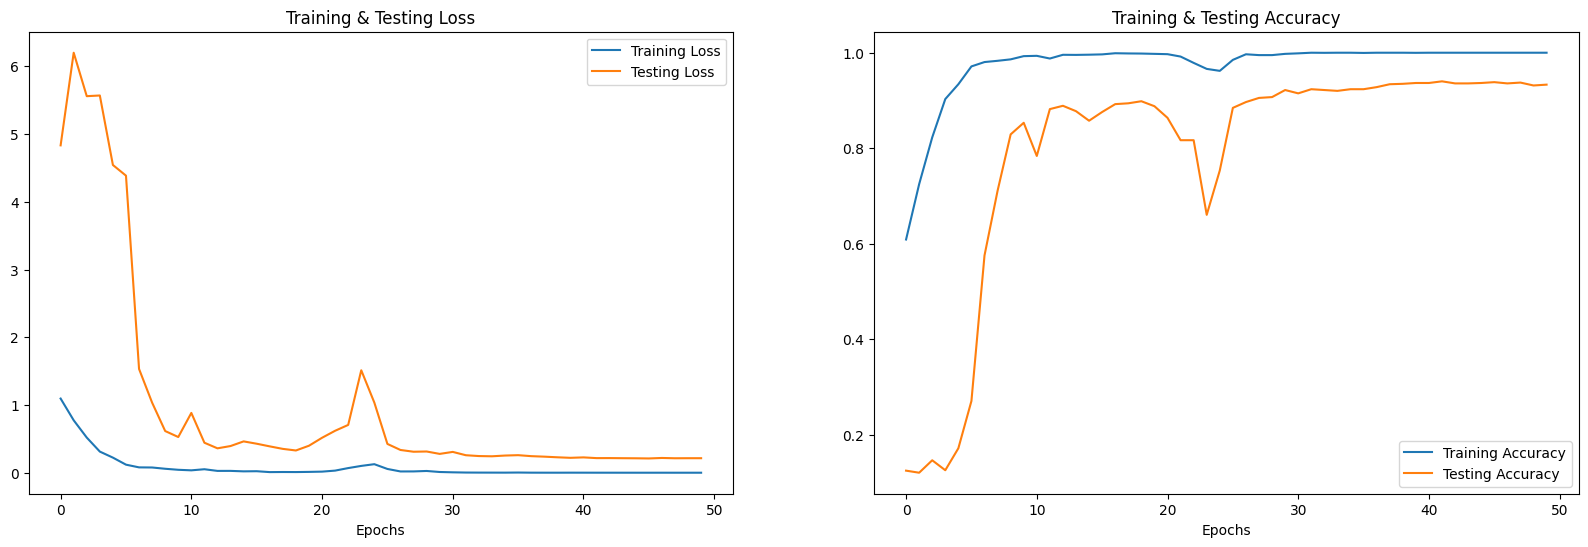

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test0 = model.predict(x_testcnn)
y_pred0 = encoder.inverse_transform(pred_test0)
y_test0 = encoder.inverse_transform(y_test)

# Check for random predictions
df0 = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df0['Predicted Labels'] = y_pred0.flatten()
df0['Actual Labels'] = y_test0.flatten()

df0.head(10)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Predicted Labels Actual Labels
0        surprised     surprised
1            angry         angry
2        surprised     surprised
3          fearful       fearful
4            happy         happy
5            angry         angry
6          disgust       disgust
7          neutral       neutral
8            angry         angry
9              sad           sad

In [ ]:
df0

Predicted Labels Actual Labels
0           surprised     surprised
1               angry         angry
2           surprised     surprised
3             fearful       fearful
4               happy         happy
...               ...           ...
1147            angry         angry
1148             calm          calm
1149              sad           sad
1150            angry         angry
1151              sad           sad

[1152 rows x 2 columns]

Evalutation

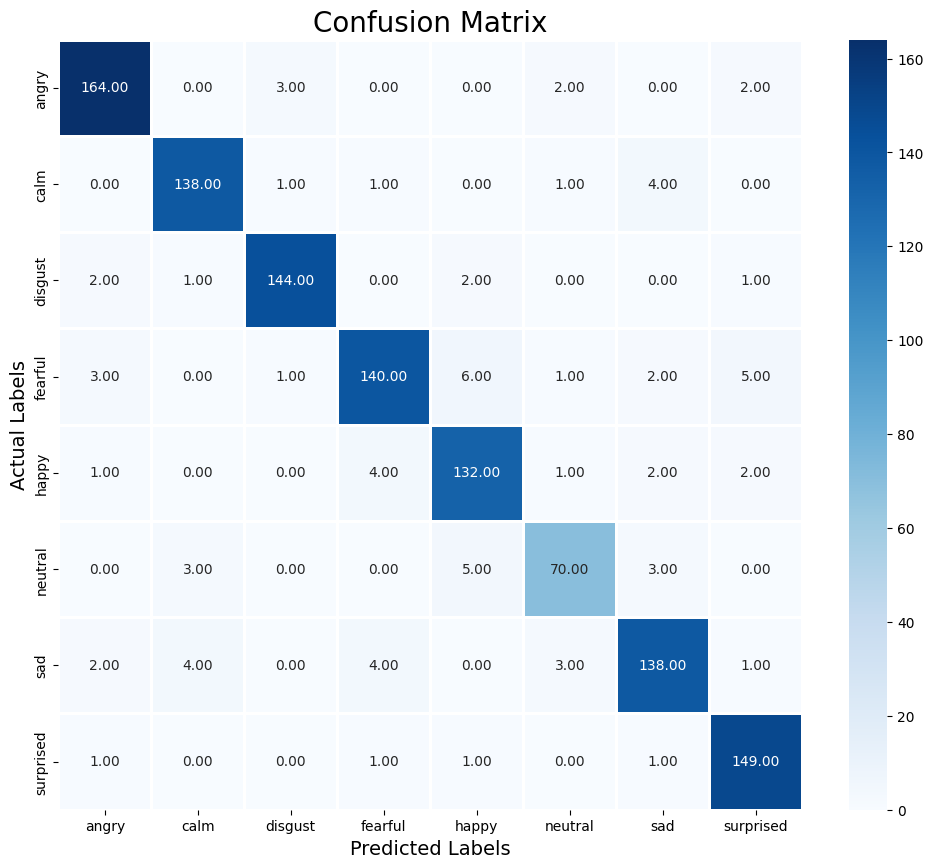

              precision    recall  f1-score   support

       angry       0.95      0.96      0.95       171
        calm       0.95      0.95      0.95       145
     disgust       0.97      0.96      0.96       150
     fearful       0.93      0.89      0.91       158
       happy       0.90      0.93      0.92       142
     neutral       0.90      0.86      0.88        81
         sad       0.92      0.91      0.91       152
   surprised       0.93      0.97      0.95       153

    accuracy                           0.93      1152
   macro avg       0.93      0.93      0.93      1152
weighted avg       0.93      0.93      0.93      1152



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test0, y_pred0)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test0, y_pred0))

Saving Best Model

In [ ]:
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from tensorflow.keras.models import Sequential, model_from_json
model_json = model.to_json()
json_path = "/content/drive/MyDrive/ML Team 35/Codes/CNN_model.json" #google drive path
with open(json_path, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
weights_path = "/content/drive/MyDrive/ML Team 35/Codes/CNN_model_weights.h5" #google drive path
model.save(weights_path)
#print("Saved model to disk")
print(f"Model and weights saved to {json_path} and {weights_path}")

Model and weights saved to /content/drive/MyDrive/ML Team 35/Codes/CNN_model.json and /content/drive/MyDrive/ML Team 35/Codes/CNN_model_weights.h5


In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

#json_file = open('/kaggle/working/CNN_model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("/kaggle/working/best_model1_weights.h5")
with open(json_path, "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(weights_path)
print("Loaded model from Google Drive")

Loaded model from Google Drive


In [ ]:
# 保存到 Google Drive
model.save("/content/drive/MyDrive/ML Team 35/Codes/SER/trained_CNN_model.keras")
print("Model saved to Google Drive successfully!")

Model saved to Google Drive successfully!


In [ ]:
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn,y_test)
#score[0]: loss , score[1]: accuracy
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9343 - loss: 0.2189
compile_metrics: 93.32%


Saving and Loading our Stnadrad Scaler and encoder

In [ ]:
import pickle

scaler_path = '/content/drive/MyDrive/ML Team 35/Codes/SER/scaler.pickle'
encoder_path = '/content/drive/MyDrive/ML Team 35/Codes/SER/encoder.pickle'

# Saving scaler
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# Loading scaler
with open(scaler_path, 'rb') as f:
    scaler2 = pickle.load(f)

# Saving encoder
with open(encoder_path, 'wb') as f:
    pickle.dump(encoder, f)

# Loading encoder
with open(encoder_path, 'rb') as f:
    encoder2 = pickle.load(f)


print("Done")

Done


Test script

In [ ]:
from tensorflow.keras.models import Sequential, model_from_json

json_path = "/content/drive/MyDrive/ML Team 35/Codes/SER/CNN_model.json" #google drive path
weights_path = "/content/drive/MyDrive/ML Team 35/Codes/SER/CNN_model_weights.h5" #google drive path

with open(json_path, 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(weights_path)

print("Loaded model from disk")

Loaded model from disk


In [ ]:
import pickle

scaler_path = '/content/drive/MyDrive/ML Team 35/Codes/SER/scaler.pickle'
encoder_path = '/content/drive/MyDrive/ML Team 35/Codes/SER/encoder.pickle'

# 从 Google Drive 加载 scaler
with open(scaler_path, 'rb') as f:
    scaler2 = pickle.load(f)

# 从 Google Drive 加载 encoder
with open(encoder_path, 'rb') as f:
    encoder2 = pickle.load(f)

print("Done")

Done


In [ ]:
import librosa
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

In [ ]:
def get_predict_feat(path):
    d, s_rate= librosa.load(path, duration=2.5, offset=0.6)
    res=extract_features(d)
    result=np.array(res)
    result=np.reshape(result,newshape=(1,2376))
    i_result = scaler2.transform(result)
    final_result=np.expand_dims(i_result, axis=2)

    return final_result

In [ ]:
# all imports
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
!pip -q install pydub
!apt-get install -y ffmpeg
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  return audio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
# 录音 5 秒
#audio = record(sec=5)

# 保存为文件
#audio_path = "/content/drive/MyDrive/ML Team 35/Codes/SER/recorded_audio.wav"
#audio.export(audio_path, format="wav")
#print(f"Audio saved to {audio_path}")

# 录音 5 秒
audio = record(sec=5)

# 保存到 Colab 本地
audio_path_colab = "/content/recorded_audio.wav"  # 保存到 Colab 的临时存储
audio.export(audio_path_colab, format="wav")
print(f"Audio saved to Colab local storage: {audio_path_colab}")

# 如果需要同时保存到 Google Drive
audio_path_drive = "/content/drive/MyDrive/ML Team 35/Codes/recorded_audio.wav"
audio.export(audio_path_drive, format="wav")
print(f"Audio also saved to Google Drive: {audio_path_drive}")


<IPython.core.display.Javascript object>

Audio saved to /content/drive/MyDrive/ML Team 35/Codes/recorded_audio.wav


In [ ]:
# 保存到 Colab 本地
audio_path_colab = "/content/recorded_audio.wav"  # 保存到 Colab 的临时存储
audio.export(audio_path_colab, format="wav")
print(f"Audio saved to Colab local storage: {audio_path_colab}")

Audio saved to Colab local storage: /content/recorded_audio.wav


In [ ]:
from IPython.display import Audio
Audio(audio_path)

In [ ]:
from IPython.display import Audio
Audio(audio_path_colab)
Audio(audio_path_drive)

In [ ]:
res=get_predict_feat(audio_path)
print(res.shape)

(1, 2376, 1)


In [ ]:
emotions1={1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fearful', 7:'Disgust',8:'Surprised'}
def prediction(path1):
    res=get_predict_feat(path1) #提取特征
    predictions=loaded_model.predict(res) #模型預測
    y_pred = encoder2.inverse_transform(predictions) #解碼預測結果
    print(y_pred[0][0])  #輸出情感類別

In [ ]:
prediction(audio_path_colab)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
calm


In [ ]:
# 加载模型
from tensorflow.keras.models import load_model
loaded_model_2 = load_model("/content/drive/MyDrive/ML Team 35/Codes/SER/trained_CNN_model.keras")

data, sr = librosa.load(audio_path_colab, duration=2.5, offset=0.6)
features = extract_features(data, sr)
# 标准化特征
features = scaler.transform(features.reshape(1, -1))
# 调整数据形状
features = np.expand_dims(features, axis=2)
# 使用加载的模型进行预测
predictions_2 = loaded_model.predict(features)
predicted_emotion = encoder.inverse_transform(predictions_2)

print("Predicted Emotion:", predicted_emotion[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Emotion: calm


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 28 variables whereas the saved optimizer has 54 variables. 
  
